# **Lawrence Abdulnour (20019894), Alexandre Marcil (C9464) and Louis-François Préville-Ratelle (708048)**

#Q3 Practical Part

In [0]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 21.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1ScxM8IBCvrRIzZ8kibYjuAfFvaYQf18U' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('testset.zip')

file_id = '1K0aWrOtUX9nT32eoWukUERkU3D8_7c-E' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('trainset.zip')

# Best Model
file_id = '1LubNJDL-as_eOjGDdaoNLJi133eExoxk' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('best.net')


In [0]:
import zipfile

zip_ref = zipfile.ZipFile('trainset.zip', "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('testset.zip', "r")
zip_ref.extractall()
zip_ref.close()

In [0]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

import gzip
import pickle
import numpy as np
import random
from random import seed
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [0]:
print(f"Your version of Pytorch is {torch.__version__}")

# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

Your version of Pytorch is 1.0.1.post2
cuda


In [0]:
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [0]:
import torchvision
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import PIL

indices = list(range(19998))
random.shuffle(indices)

n_valid = 2400
BATCH_SIZE = 16
TRAIN_DATA_PATH = "./trainset/"
TEST_DATA_PATH = "./testset/"

TRANSFORM_IMG_AUG = transforms.Compose([
    transforms.ColorJitter(brightness=0.04, contrast=0.04, saturation=0.05, hue=0.05),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(25, translate=None, scale=None, shear=20, resample=False, fillcolor=0),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4897, 0.4547, 0.4160],
                         std=[0.25, 0.25, 0.25] )])

TRANSFORM_IMG = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4897, 0.4547, 0.4160],
                         std=[0.25, 0.25, 0.25] )])

train_data = ImageFolderWithPaths(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_AUG)
valid_data = ImageFolderWithPaths(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data  = ImageFolderWithPaths(root=TEST_DATA_PATH,  transform=TRANSFORM_IMG)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, sampler=SubsetRandomSampler(indices[n_valid:]))
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, sampler=SubsetRandomSampler(indices[:n_valid]))
test_loader  = data.DataLoader(test_data,  batch_size=BATCH_SIZE, num_workers=4, shuffle=False) 

# training set without data augmentation (image modifications)
train_loader2 = data.DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, sampler=SubsetRandomSampler(indices[n_valid:]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['1032']
./trainset/Cat/1032.Cat.jpg
tensor(0)


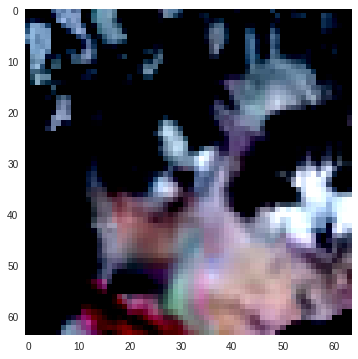

In [0]:
import re
# visualize and understand the data
for inputs, targets, path in train_loader:
    i=5
    plt.figure(figsize=(6,6))
    img = inputs[i]
    img = img.permute(1,2,0)
    print(re.findall('\d+', path[i]))
    print(path[i])
    plt.grid(False)
    plt.imshow(img)
    print(targets[i])
    break

In [0]:
class SuperNet(nn.Module):
    def __init__(self):
        super(SuperNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU())
        
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU())
        
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.block5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU())
        
        self.block6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.block7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU())
            
         
        self.fc1 = nn.Linear(8*8*128, 250)
            
        self.fc2 = nn.Linear(250, 2)
        
        
        
    def forward(self, x):
        out = self.block1(x)

        out = self.block2(out)
        
        out = self.block3(out)
        
        out = self.block4(out)
            
        out = self.block5(out)
        
        out = self.block6(out)
            
        out = self.block7(out) 
        
        # Flatten the output of block2
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        
        out = self.fc2(out)
        
        return out
        
model = SuperNet()
model = model.to(device)

print(model)
print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

SuperNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (block4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (block6): Sequential(
    (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block7): Sequen

In [0]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')


In [0]:
def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    train_loss = 0
    correct = 0
    train_size = 0
    for batch_idx, (inputs, target, path) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        
        # Let them code what's here
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        ###
        train_size += len(inputs)
        train_loss += test_loss_fn(output, target).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss /= train_size
    accuracy = correct / train_size
#     print('\Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss, correct, train_size,
#         100. * accuracy))
    
    return train_loss, accuracy

In [0]:
def test(model, test_loader, split="test"):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target, path in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            # let them code what's here
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    
    print('\n' + split + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

In [0]:
best_acc = 0.9475
best_epoch = 73

In [0]:
import time
since = time.time()

model.load_state_dict(torch.load('last.net'))

lr = 0.001   # 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr)

# best_loss = 1000
# best_acc = 0

# results_train = {'loss': [], 'accuracy':[]}
# results_test = {'loss': [], 'accuracy':[]}

num_epochs = 100
for epoch in range(76, num_epochs+1):
    
    loss_train, acc_train = train(model, train_loader, optimizer, epoch)
    loss_valid, acc_valid = test(model, valid_loader)
    
    # save results every epoch
    results_train['loss'].append(loss_train)
    results_train['accuracy'].append(acc_train)
    
    results_test['loss'].append(loss_valid)
    results_test['accuracy'].append(acc_valid)
    
    if acc_valid > best_acc:
        best_acc = acc_valid
        torch.save(model.state_dict(), 'best.net')
        best_epoch = epoch
   
time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('\nbest epoch : ', best_epoch, best_acc)

torch.save(model.state_dict(), 'last.net')  



Train Epoch: 76 [0/17600 (0%)]	Loss: 0.136401
Train Epoch: 76 [8000/17600 (45%)]	Loss: 0.008723
Train Epoch: 76 [16000/17600 (91%)]	Loss: 0.111664

test set: Average loss: 0.1832, Accuracy: 2261/2400 (94.21%)

Train Epoch: 77 [0/17600 (0%)]	Loss: 0.176501
Train Epoch: 77 [8000/17600 (45%)]	Loss: 0.008988
Train Epoch: 77 [16000/17600 (91%)]	Loss: 0.019132

test set: Average loss: 0.1831, Accuracy: 2251/2400 (93.79%)

Train Epoch: 78 [0/17600 (0%)]	Loss: 0.039891
Train Epoch: 78 [8000/17600 (45%)]	Loss: 0.017358
Train Epoch: 78 [16000/17600 (91%)]	Loss: 0.002182

test set: Average loss: 0.1886, Accuracy: 2257/2400 (94.04%)

Train Epoch: 79 [0/17600 (0%)]	Loss: 0.020552
Train Epoch: 79 [8000/17600 (45%)]	Loss: 0.075481
Train Epoch: 79 [16000/17600 (91%)]	Loss: 0.001146

test set: Average loss: 0.1805, Accuracy: 2262/2400 (94.25%)

Train Epoch: 80 [0/17600 (0%)]	Loss: 0.052385
Train Epoch: 80 [8000/17600 (45%)]	Loss: 0.014248
Train Epoch: 80 [16000/17600 (91%)]	Loss: 0.035860

test set: Av

In [0]:
saved_model = open("model.pickle", "wb")
pickle.dump({0: results_train, 1: results_test, 2: indices}, saved_model)
saved_model.close()

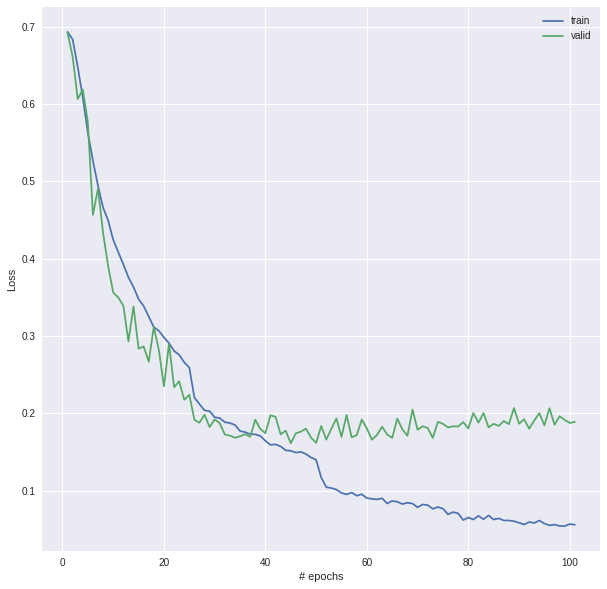

In [0]:
plt.figure(figsize=(10,10))
# Plot training and validation curve
x = range(1, num_epochs + 2)
plt.plot(x, results_train["loss"], label='train')
plt.plot(x, results_test["loss"], label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


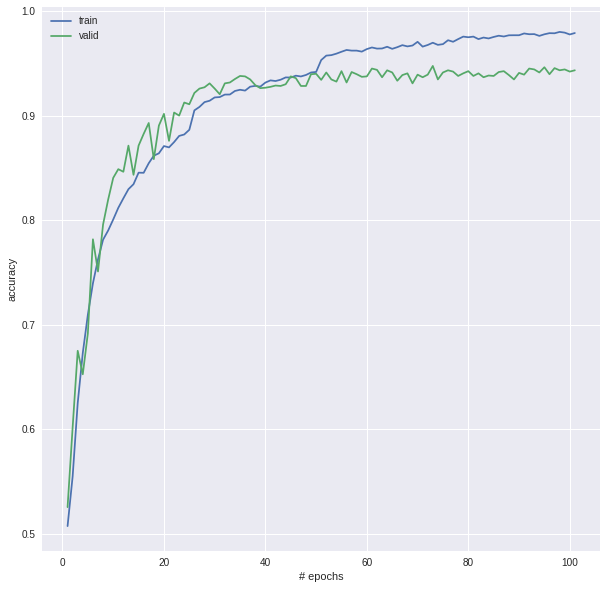

In [0]:
# Plot training and validation curve
x = range(1, num_epochs+2)
plt.figure(figsize=(10,10))
plt.plot(x, results_train["accuracy"], label='train')
plt.plot(x, results_test["accuracy"], label='valid')

plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [0]:
###  Making predictions on Test set.
model.load_state_dict(torch.load('best.net'))

# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# pred_labels = np.zeros(5000)
pred_labels = np.array([])
paths = np.array([])

# Iterate over test data
for i, (images, labels, path) in enumerate(test_loader):
    
    # put images on proper device (GPU)
    images = images.to(device)
    labels = labels.to(device)

    # Forward
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    pred_labels = np.hstack((pred_labels, np.asarray(predicted.cpu())))
    paths = np.hstack((paths, np.asarray(path)))
   
    # Statistics
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

# print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

print(pred_labels)



[0. 0. 0. ... 1. 0. 1.]


In [0]:
labels={0: 'Cat', 1:'Dog'}
pred_names=list(0. for i in range(4999))
pred_index=list(0. for i in range(4999))
for i in range(4999):
    pred_names[i] = labels[int(pred_labels[i])]
    pred_index[i ]= int(re.findall('\d+', paths[i])[0])
print(pred_names)

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat', 'Cat'

In [0]:
merged = np.vstack((pred_names, pred_index))
merged = np.transpose(merged)

In [0]:
import pandas as pd
prediction = pd.DataFrame(merged, columns=['label', 'id']) #.to_csv('prediction.csv', index_label='Id')

prediction["id"] = pd.to_numeric(prediction["id"])
prediction = prediction.sort_values('id')
prediction = prediction.to_csv('prediction.csv', index=False, columns=['id', 'label'])


In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

# Upload the file to Drive.

from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'prediction5.csv',
  'mimeType':'text/plain'
}
media = MediaFileUpload('prediction.csv', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 15tJB9n6Ln1nKMLSyXvrWbhqN501x76i-


In [0]:
### BACKUP3
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'best.net',
  'mimeType': None
}
media = MediaFileUpload('best.net', 
                        mimetype= None,
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))


File ID: 1GXXMyh03mwGJ_wxlnrXBeRiTCL1HfSAS


In [0]:
### Q3 : missclassified images.

def PredProb(dataloader):
# Set model to evaluate mode
    model.eval()

    sm = torch.nn.Softmax()

    correct = 0
    total = 0

    pred_labels = np.array([])
    paths = np.array([])
    probCat = np.array([])
    probDog = np.array([])
    true_labels = np.array([])

    # Iterate over test data
    for i, (images, labels, path) in enumerate(dataloader):

        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels = np.hstack((true_labels, np.asarray(labels.cpu())))
        pred_labels = np.hstack((pred_labels, np.asarray(predicted.cpu())))
        paths = np.hstack((paths, np.asarray(path)))
        prob= np.asarray(sm(outputs).cpu().detach().numpy()) 

        probCat = np.hstack((probCat, (prob[:,0])))
        probDog = np.hstack((probDog, (prob[:,1])))

        # Statistics
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)

    print('Accuracy on the set: {:.2f}%'.format(100 * correct / total))

#     print(pred_labels)
    
    return (pred_labels, paths, probCat, probDog, true_labels)



In [0]:
validpred = PredProb(valid_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy on the set: 99.00%


In [0]:
# Q3: 50% prediction

from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

paths   = validpred[1]
probCat = validpred[2]
probDog = validpred[3]
true_labels = validpred[4]

listCatDog = []
for i in range(2400):
  if probCat[i] < 0.6 and probCat[i] > 0.4:
    print(probCat[i], i, paths[i]) 
    image = imread(paths[i])  
    listCatDog.append((paths[i], probCat[i]))

0.5727967023849487 80 ./trainset/Dog/7595.Dog.jpg
0.4592713713645935 207 ./trainset/Cat/1828.Cat.jpg
0.5448853969573975 375 ./trainset/Dog/4370.Dog.jpg
0.5972806811332703 1207 ./trainset/Cat/7291.Cat.jpg


In [0]:
def plotImages(listCatDog, columns, index):
  fig=plt.figure(figsize=(15, 15))

  for i in range(1, columns*rows +1):
      fig.add_subplot(1, columns, i)
      image = imread(listCatDog[i-1+index][0])  
      plt.title(listCatDog[i-1+index][0] + '\nCat prob:' + str(round(listCatDog[i-1+index][1], 3)))
      plt.grid(False)
      plt.imshow(image)
  plt.show()

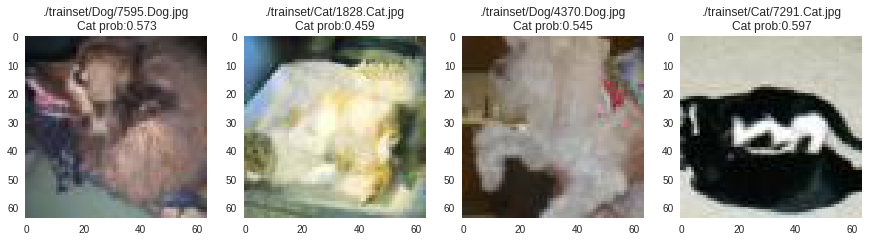

In [0]:
plotImages(listCatDog, 4, 0)

In [0]:
# Q3 : missclassified with high confidence
Catcount = 0
Dogcount = 0

listMissCats = []  # missclassified cats
listMissDogs = []  # missclassified dogs

for i in range(2400):  #17598
  if true_labels[i] == 0 and probCat[i] < 0.25 :   
    Catcount += 1
    listMissCats.append((paths[i], probCat[i]))  

  if true_labels[i] == 1 and probDog[i] < 0.25:
    Dogcount += 1
    listMissDogs.append((paths[i], probCat[i]))
print ("missclassified cats: ", Catcount)
print ("missclassified dogs: ", Dogcount)

missclassified cats:  13
missclassified dogs:  2


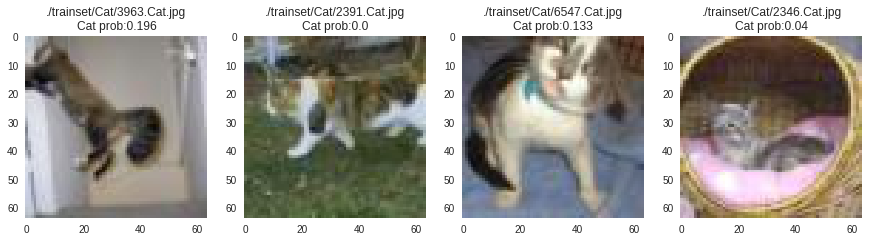

In [0]:
plotImages(listMissCats, 4, 0)

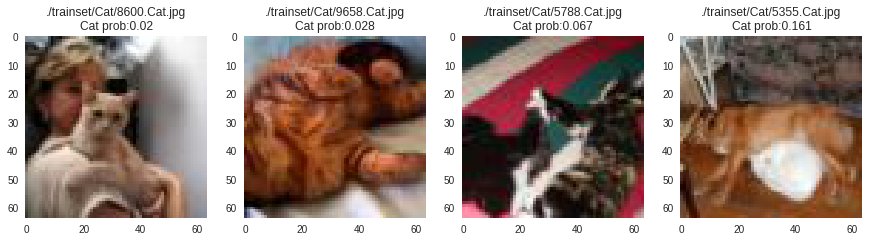

In [0]:
plotImages(listMissCats, 4, 4)

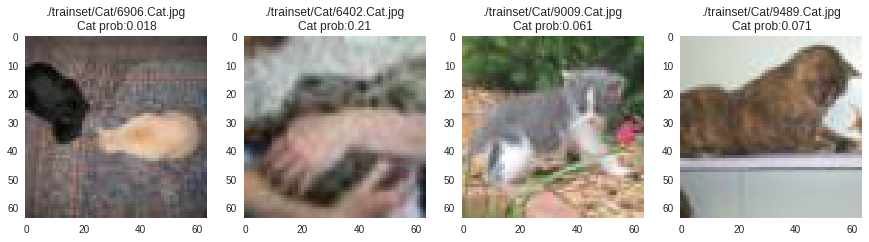

In [0]:
plotImages(listMissCats, 4, 8)

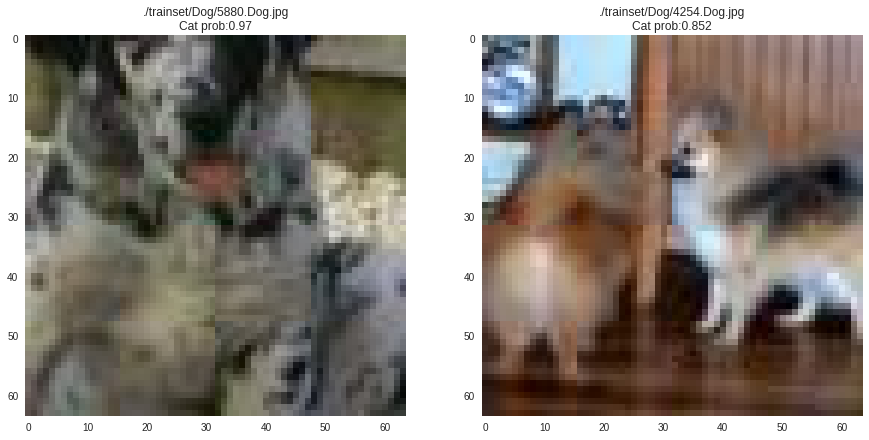

In [0]:
plotImages(listMissDogs, 2, 0)

In [0]:
# missclassification on the training set (without image modifications (data augmentation))
trainpred = PredProb(train_loader2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy on the set: 98.00%


In [0]:
# 50% prediction from train set

from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

probCat = trainpred[2]
paths   = trainpred[1]
probDog = trainpred[3]
true_labels = trainpred[4]

listCatDogT = []
for i in range(17598):
  if probCat[i] < 0.55 and probCat[i] > 0.45:
    print(probCat[i], i, paths[i]) 
    image = imread(paths[i])  
    listCatDogT.append((paths[i], probCat[i]))

0.5324743986129761 1468 ./trainset/Dog/4306.Dog.jpg
0.5295772552490234 1785 ./trainset/Cat/655.Cat.jpg
0.5472022891044617 3386 ./trainset/Cat/5569.Cat.jpg
0.5322353839874268 3612 ./trainset/Cat/9307.Cat.jpg
0.48128804564476013 4013 ./trainset/Dog/9135.Dog.jpg
0.47286126017570496 4134 ./trainset/Cat/6464.Cat.jpg
0.46052858233451843 4704 ./trainset/Cat/4952.Cat.jpg
0.491077721118927 5523 ./trainset/Cat/4913.Cat.jpg
0.5179921388626099 7398 ./trainset/Cat/6265.Cat.jpg
0.5097129940986633 7592 ./trainset/Cat/8418.Cat.jpg
0.4508996605873108 9845 ./trainset/Cat/8126.Cat.jpg
0.511404812335968 10056 ./trainset/Cat/8028.Cat.jpg
0.5481572151184082 11628 ./trainset/Dog/3519.Dog.jpg
0.5106284022331238 12227 ./trainset/Cat/539.Cat.jpg
0.5486811995506287 12405 ./trainset/Cat/1003.Cat.jpg
0.5209543704986572 12496 ./trainset/Cat/5811.Cat.jpg
0.45797696709632874 12628 ./trainset/Dog/6425.Dog.jpg
0.4525091350078583 12753 ./trainset/Cat/1485.Cat.jpg
0.5015993714332581 13862 ./trainset/Cat/3228.Cat.jpg
0.48

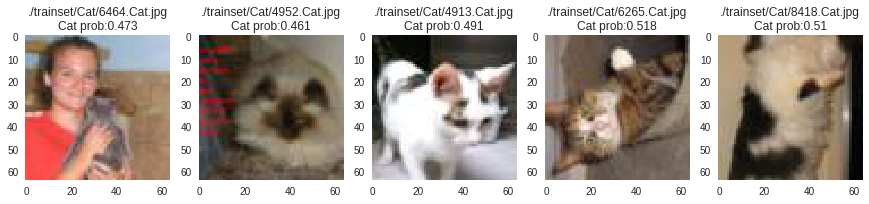

In [0]:
plotImages(listCatDogT, 5, 5)

In [0]:
# missclassified  (from training set)
Catcount = 0
Dogcount = 0

listMissCatsT = []  # missclassified cats
listMissDogsT = []  # missclassified dogs

for i in range(17598):
  if true_labels[i] == 0 and probCat[i] < 0.1 :   
    Catcount += 1
    listMissCatsT.append((paths[i], probCat[i]))  

  if true_labels[i] == 1 and probDog[i] < 0.1:
    Dogcount += 1
    listMissDogsT.append((paths[i], probCat[i]))
print ("missclassified cats: ", Catcount)
print ("missclassified dogs: ", Dogcount)

missclassified cats:  72
missclassified dogs:  17


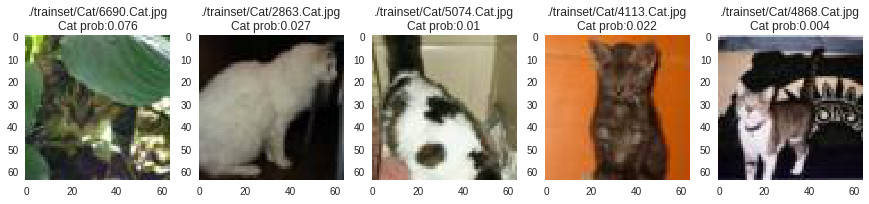

In [0]:
plotImages(listMissCatsT, 5, 0)

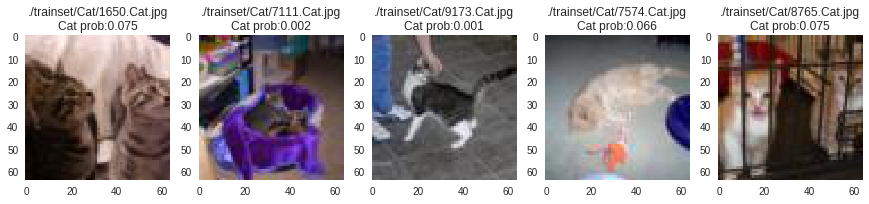

In [0]:
plotImages(listMissCatsT, 5, 10)

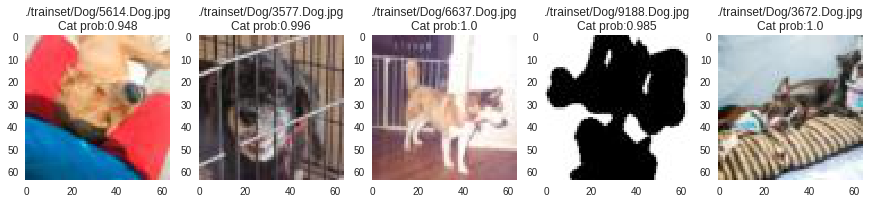

In [0]:
plotImages(listMissDogsT, 5, 0)

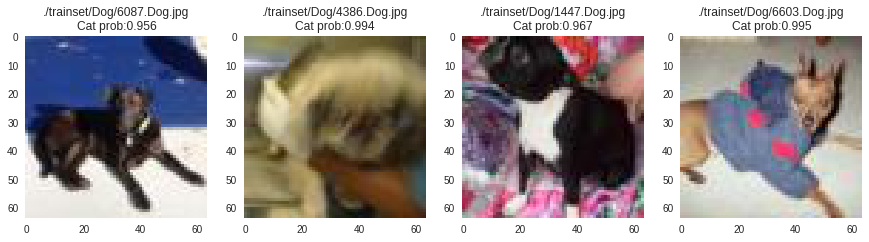

In [0]:
plotImages(listMissDogsT, 4, 5)

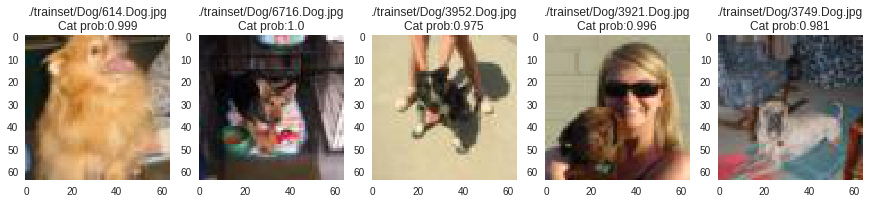

In [0]:
plotImages(listMissDogsT, 5, 10)